This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import MODEL
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = MODEL
model.fit(tf_dataset)

print(model.summary())
```

# Import the library

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

'''# Comment this if the data visualisations doesn't work on your side
%matplotlib inline'''

"# Comment this if the data visualisations doesn't work on your side\n%matplotlib inline"

In [8]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.15.0


# Load the dataset


In [9]:
# File path
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
# Read file
train_set = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(train_set.shape))

Full train dataset shape is (1460, 81)


The train data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [10]:
train_set.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [11]:
train_set = train_set.drop('Id', axis=1)
train_set.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [12]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [13]:
list_of_type = list(set(train_set.dtypes.tolist()))
print(list_of_type)

[dtype('int64'), dtype('float64'), dtype('O')]


# Overview

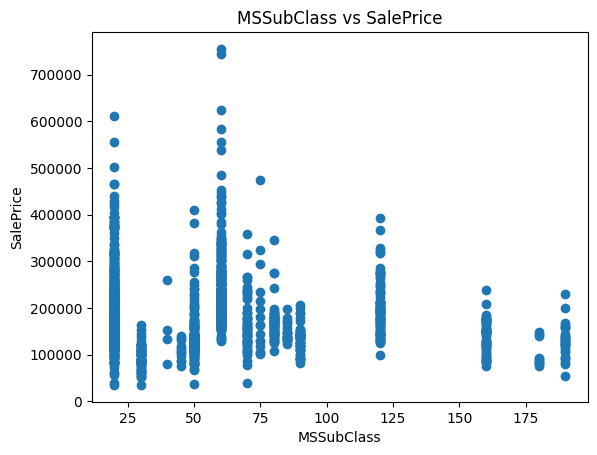

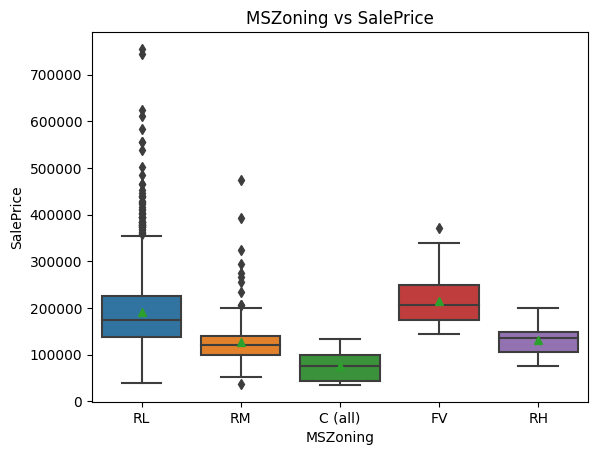

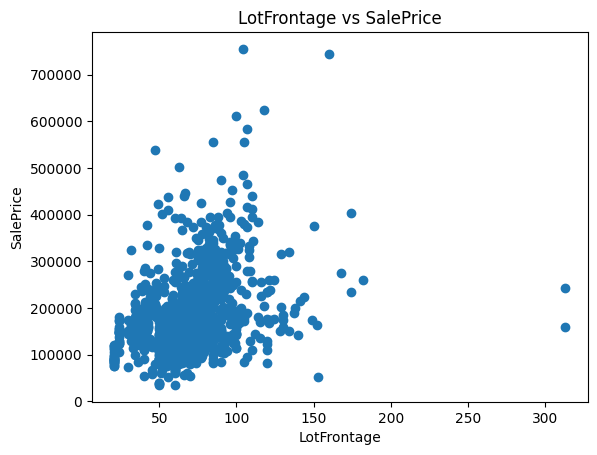

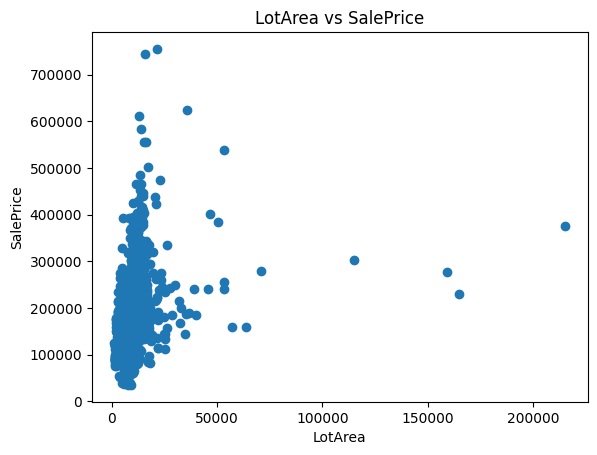

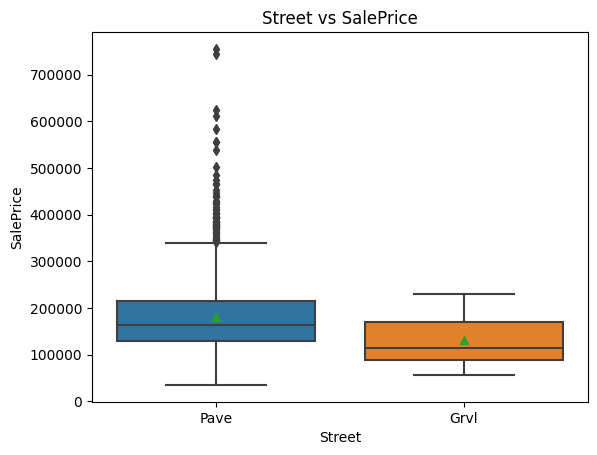

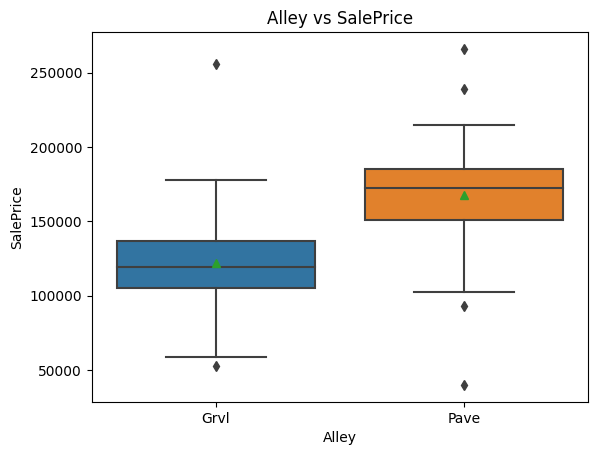

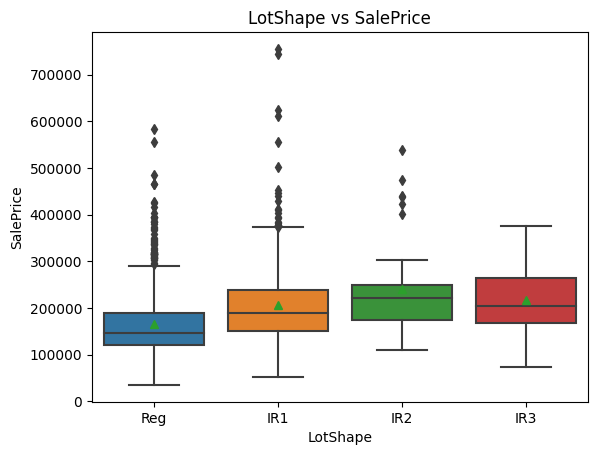

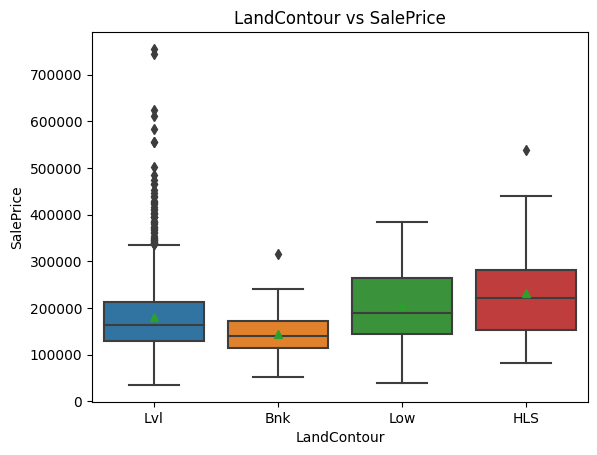

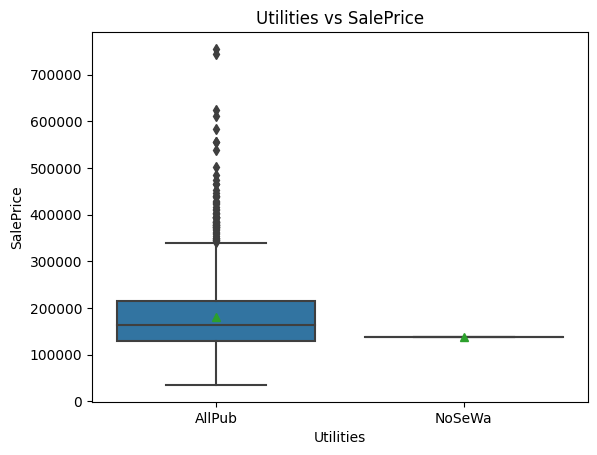

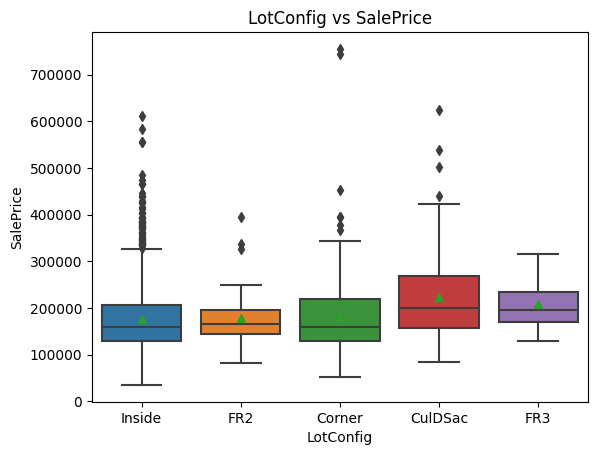

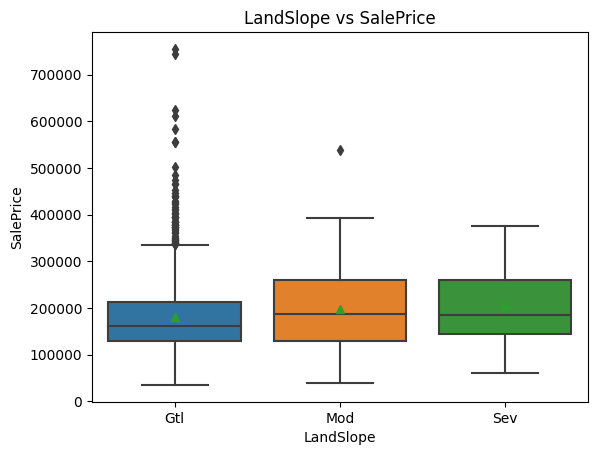

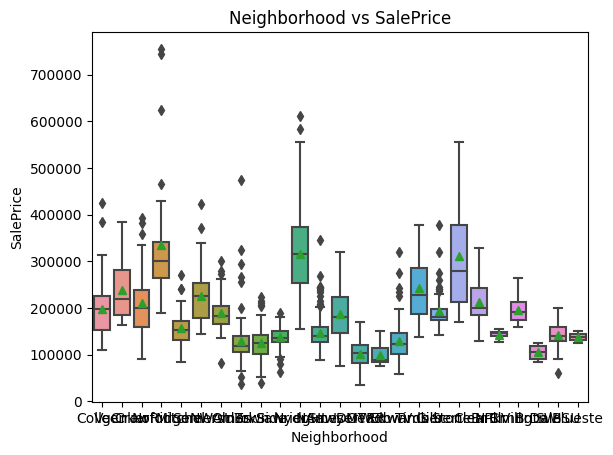

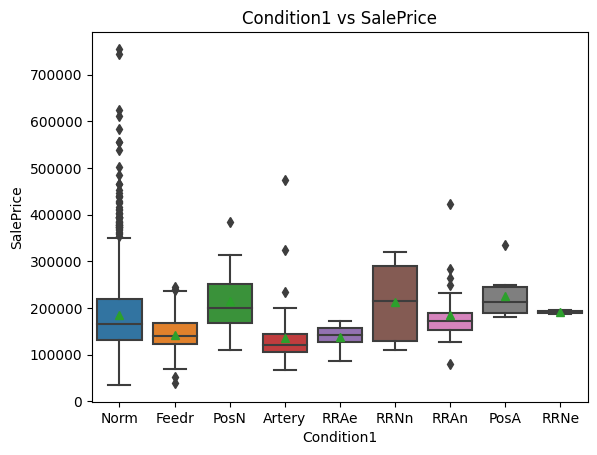

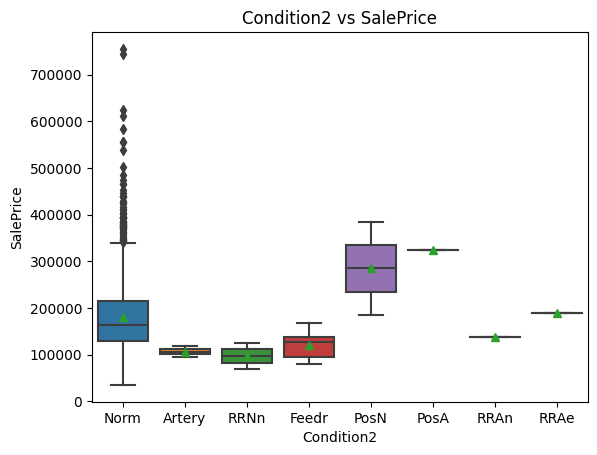

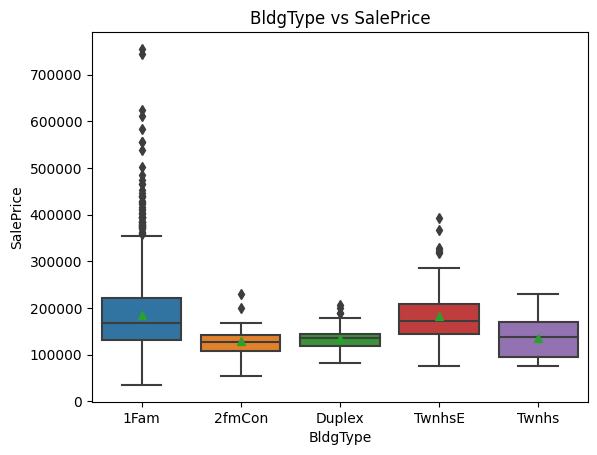

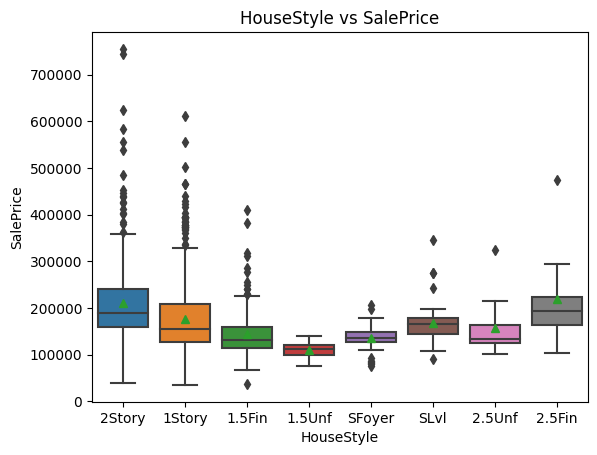

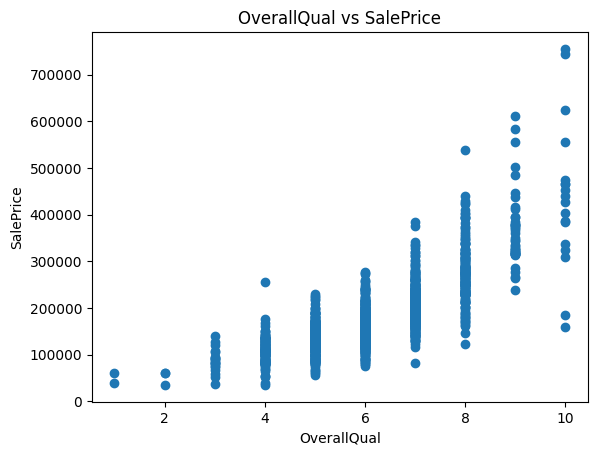

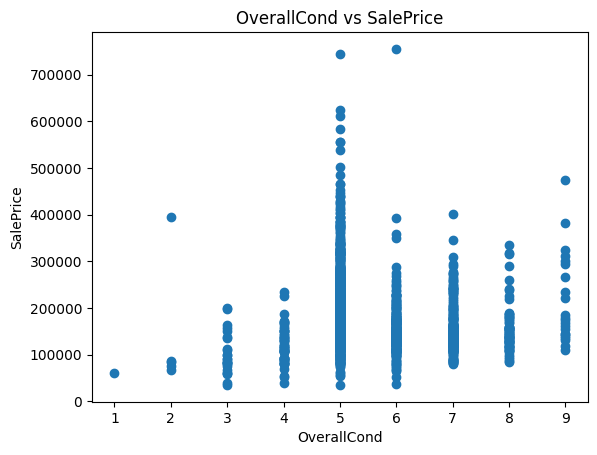

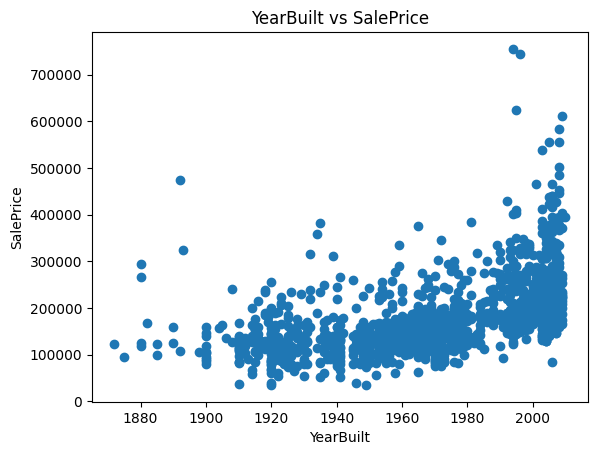

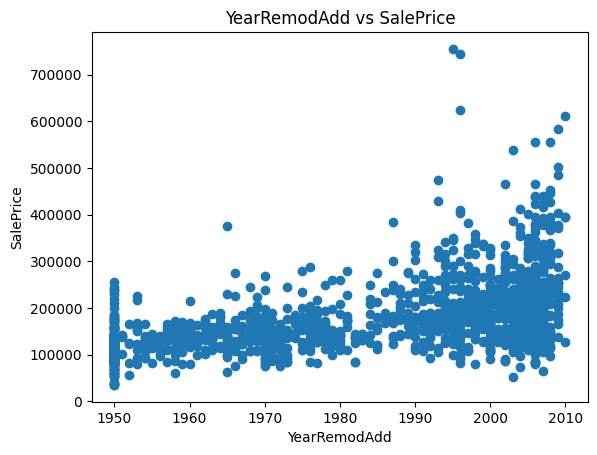

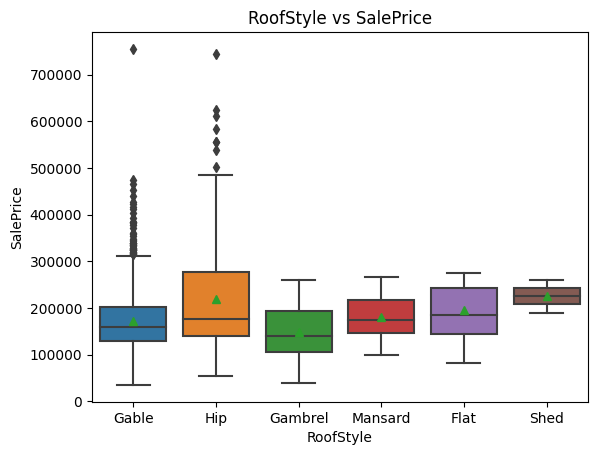

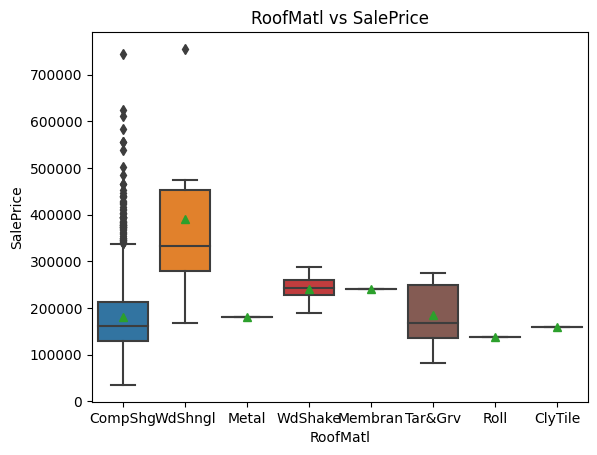

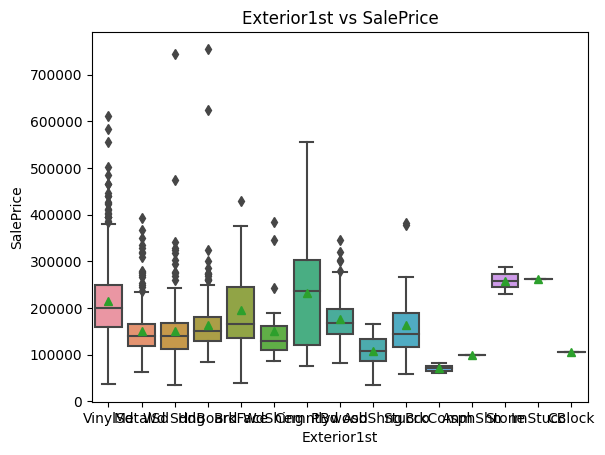

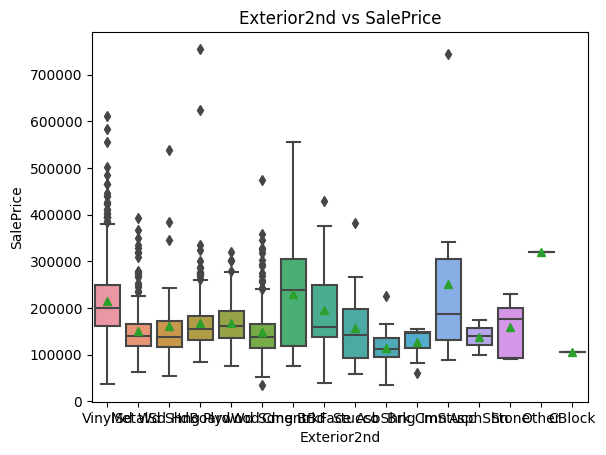

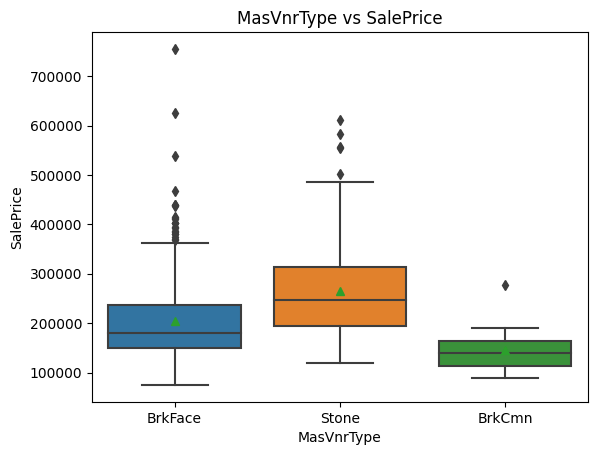

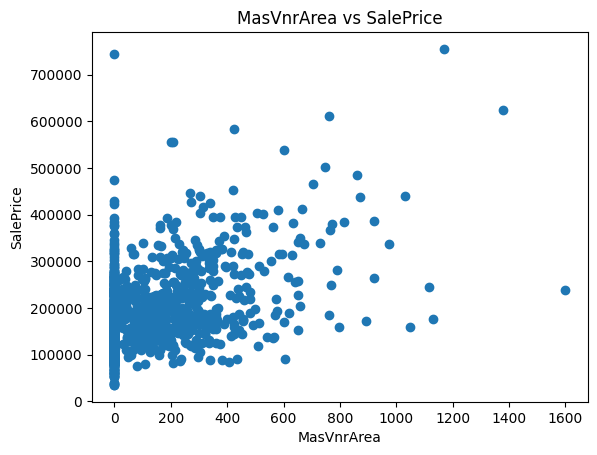

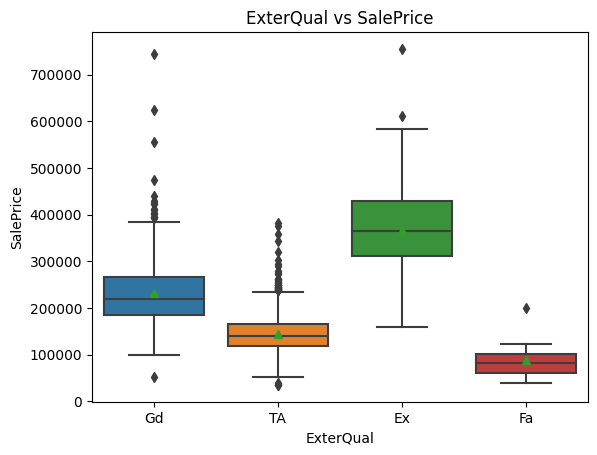

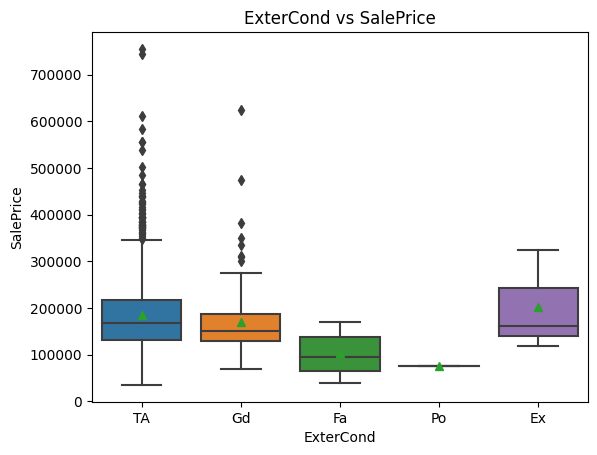

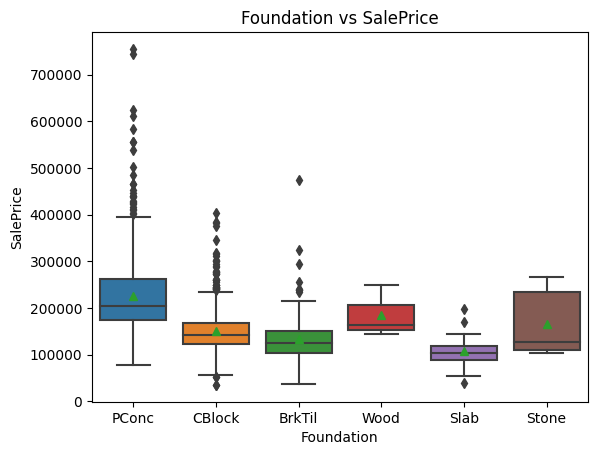

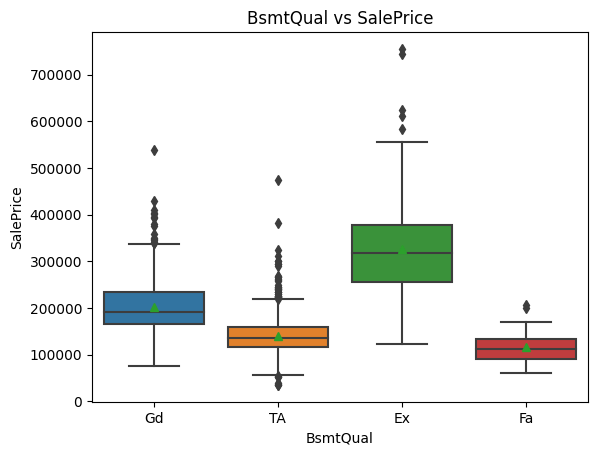

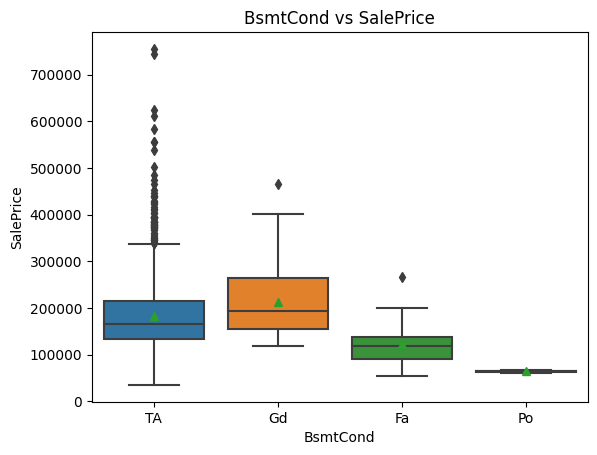

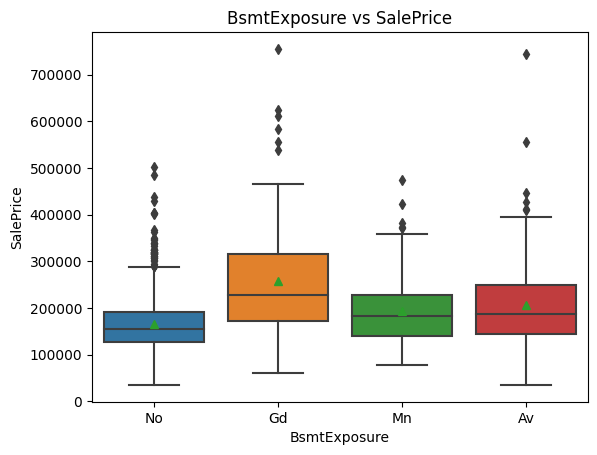

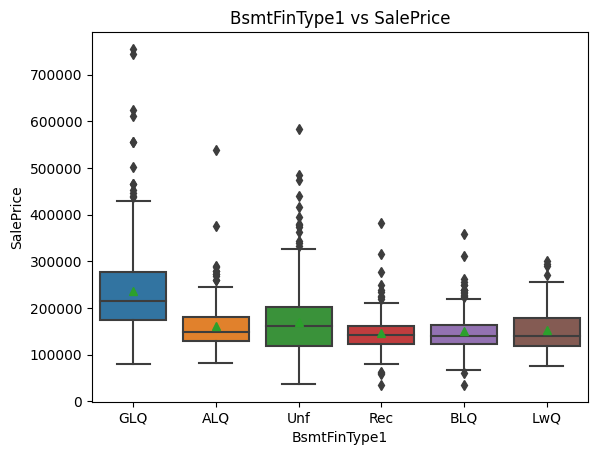

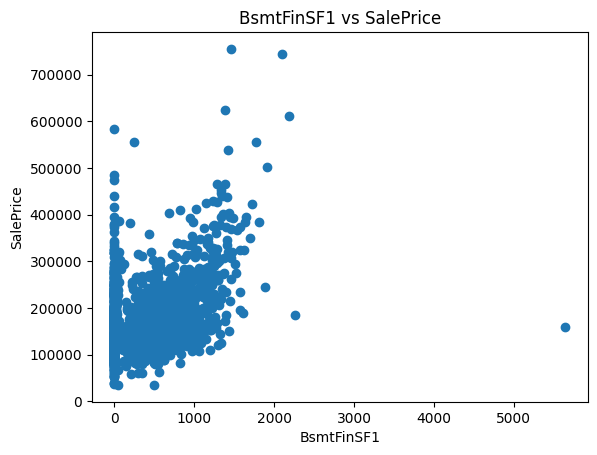

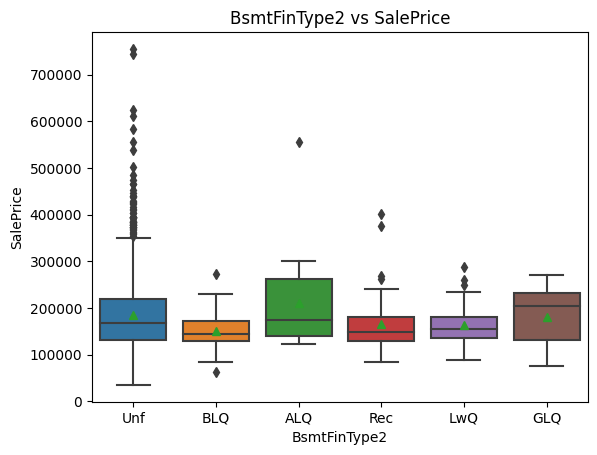

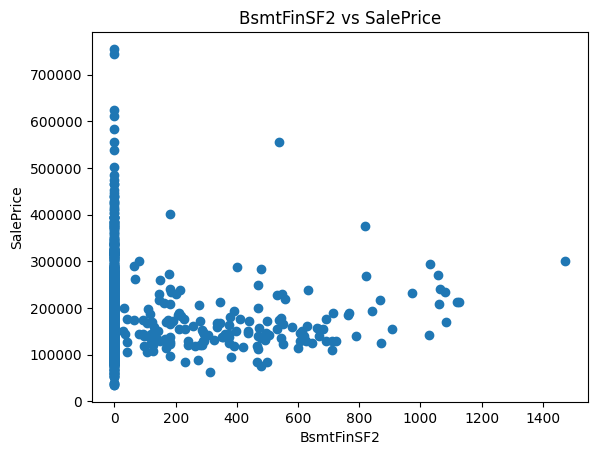

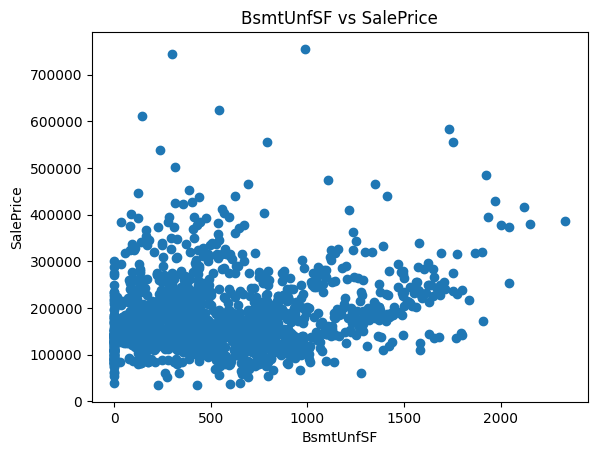

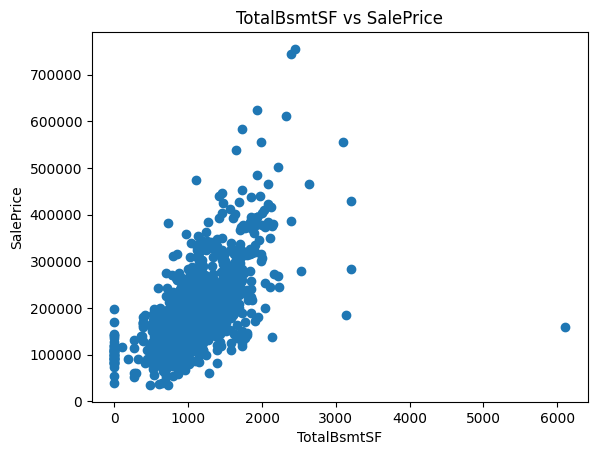

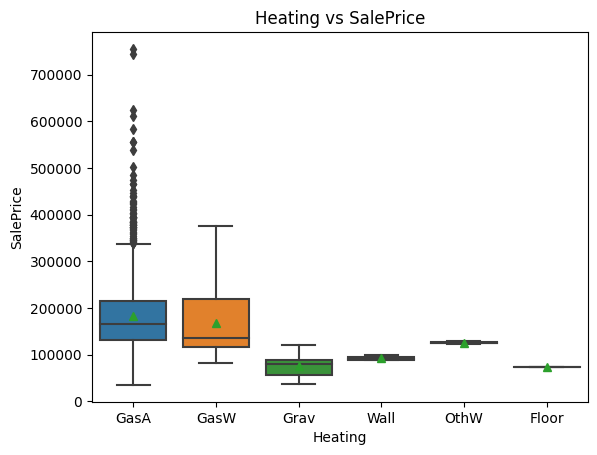

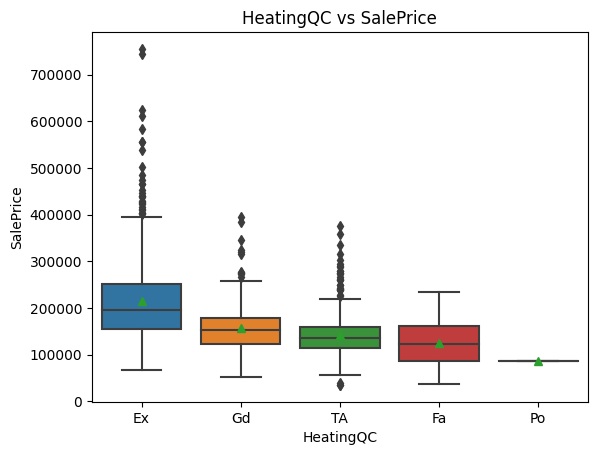

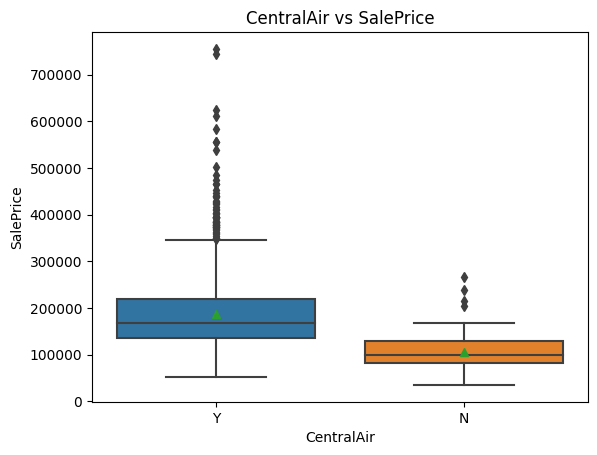

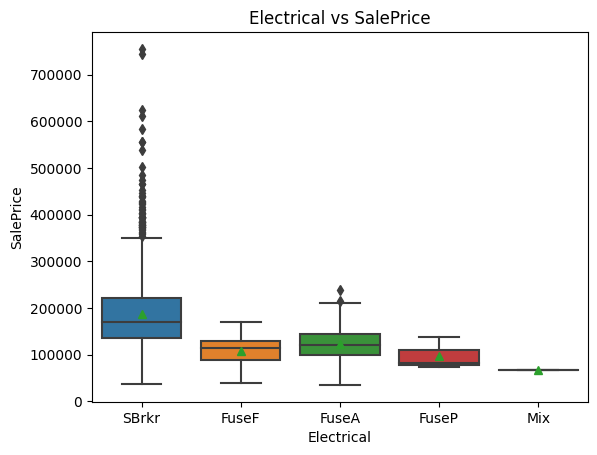

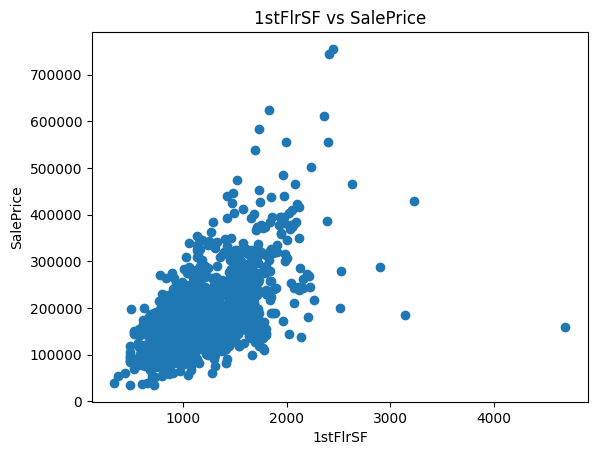

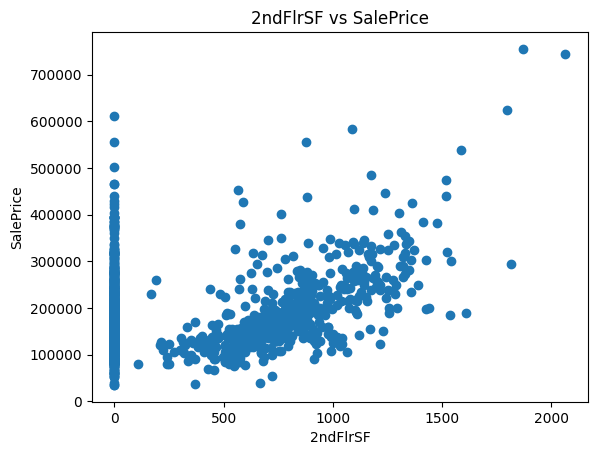

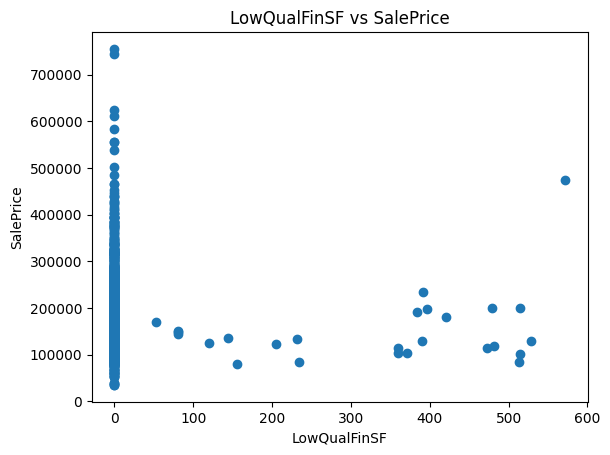

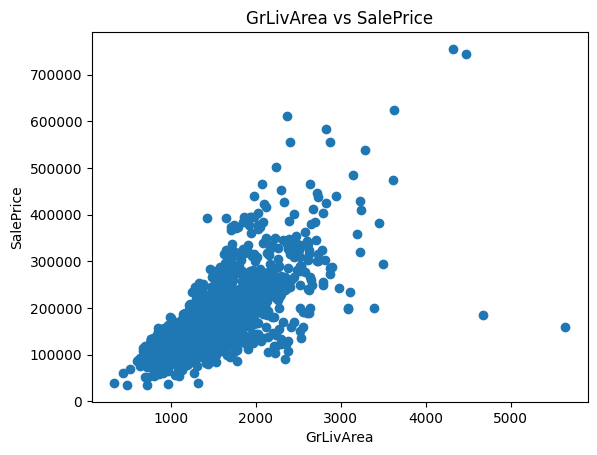

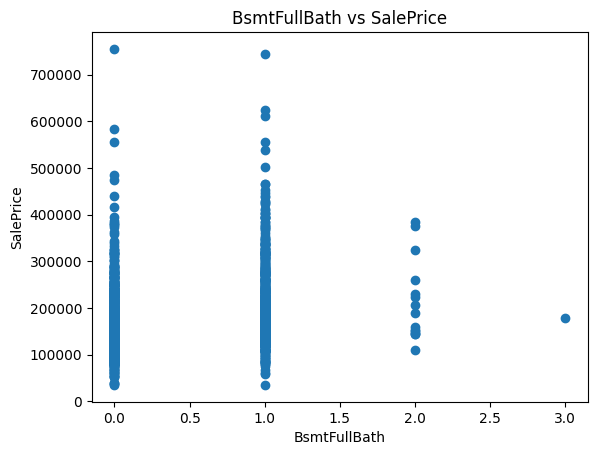

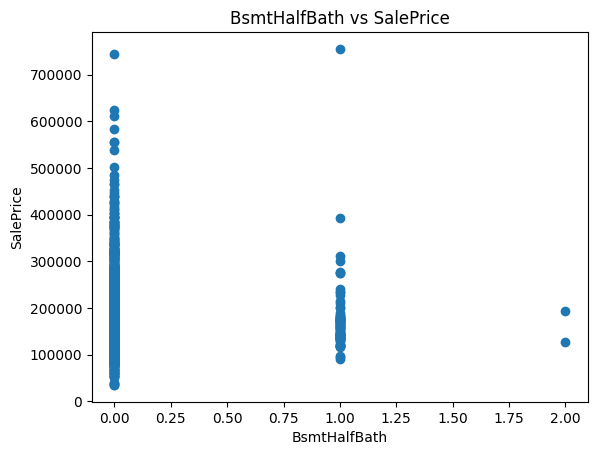

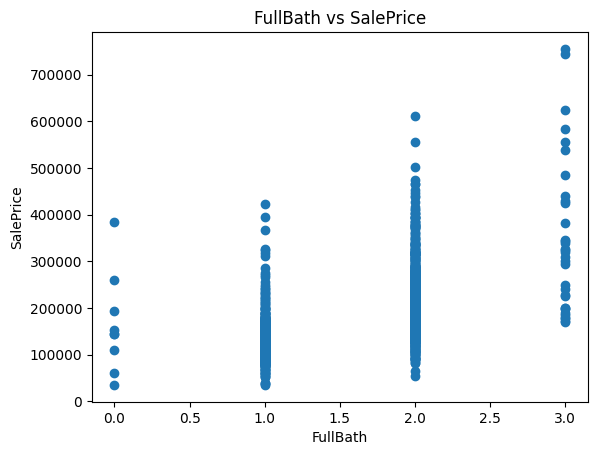

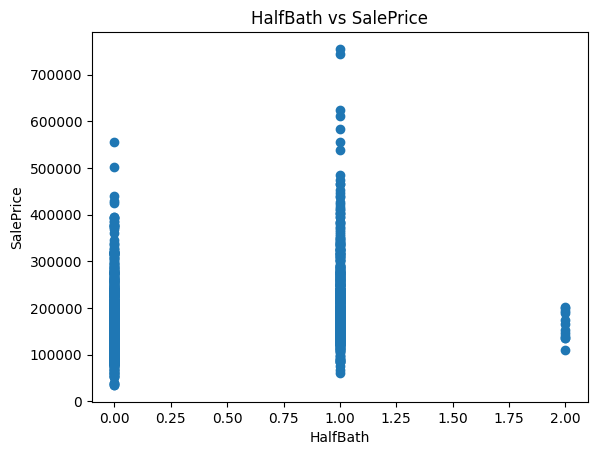

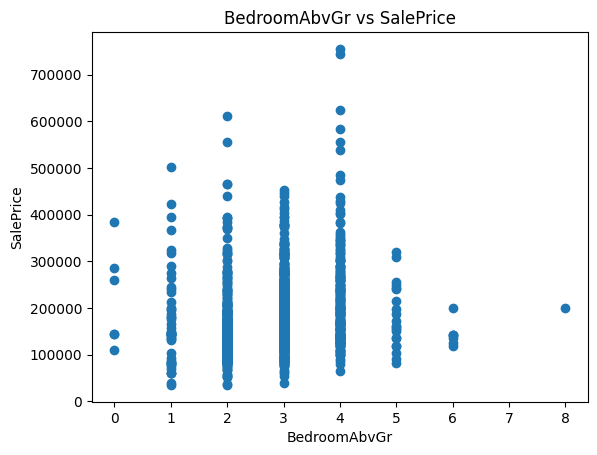

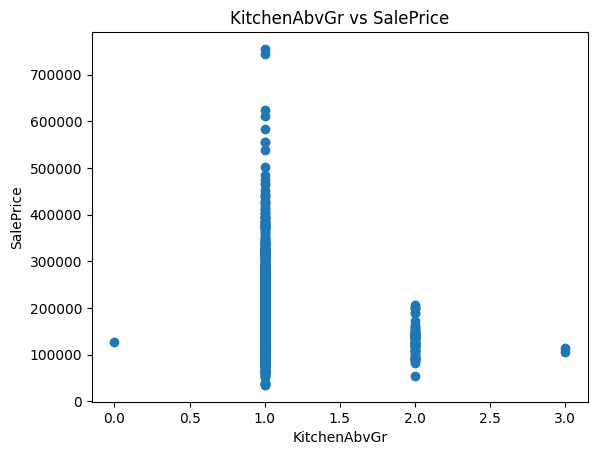

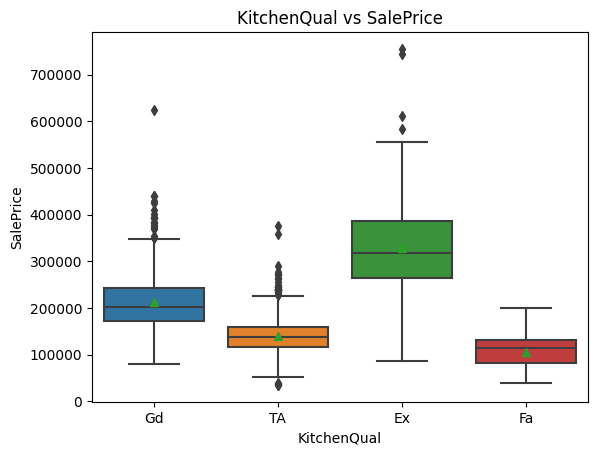

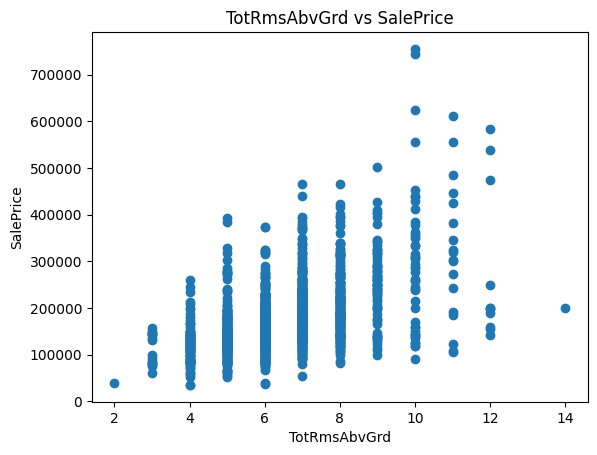

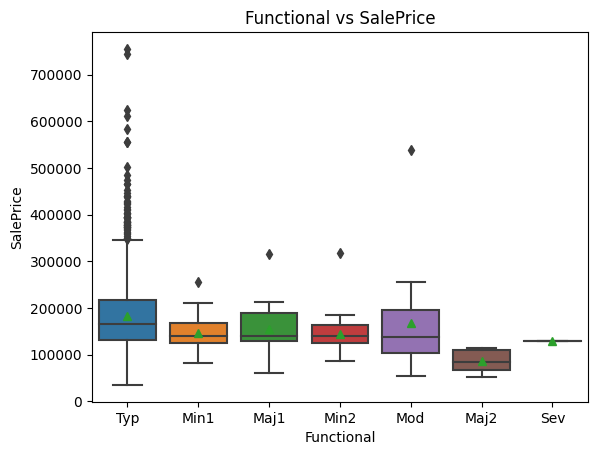

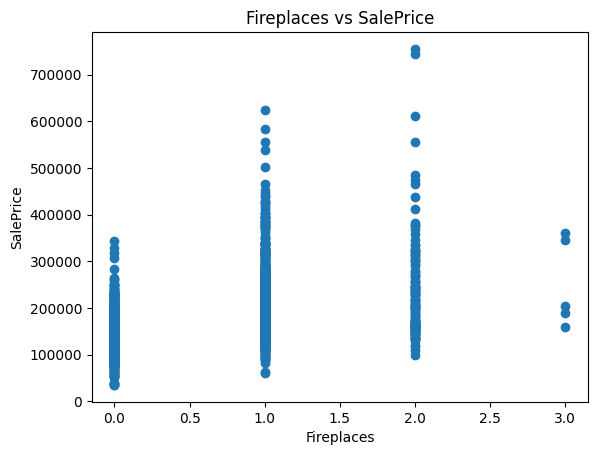

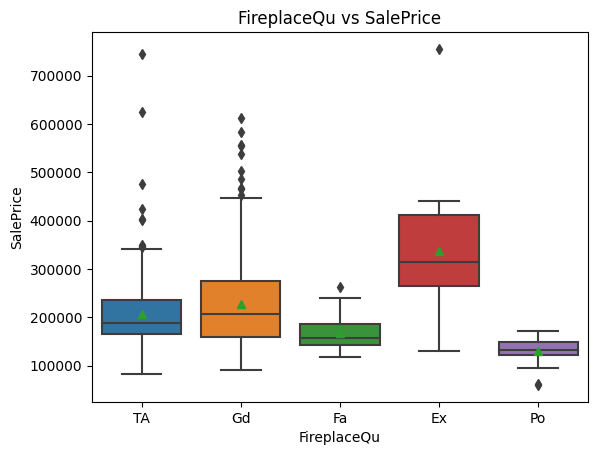

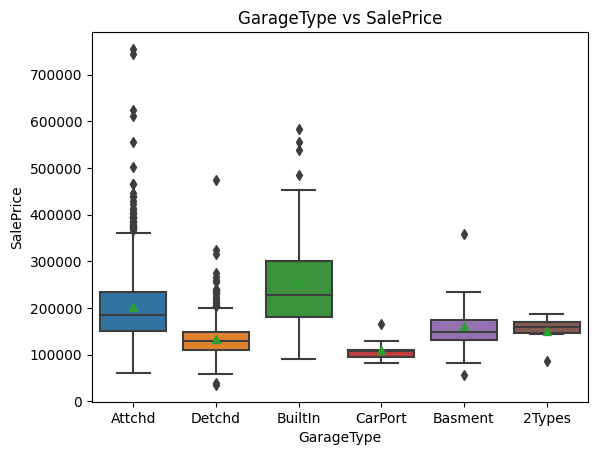

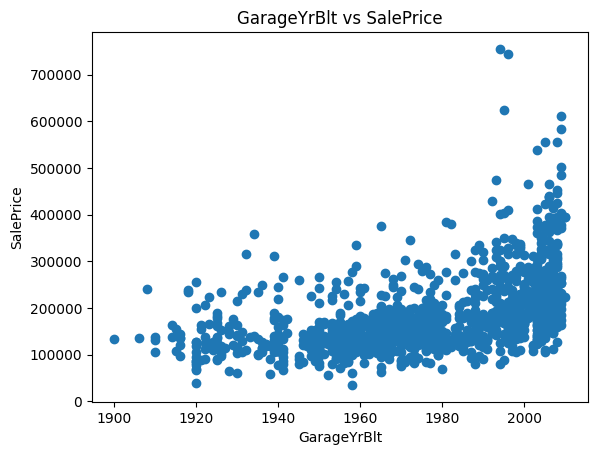

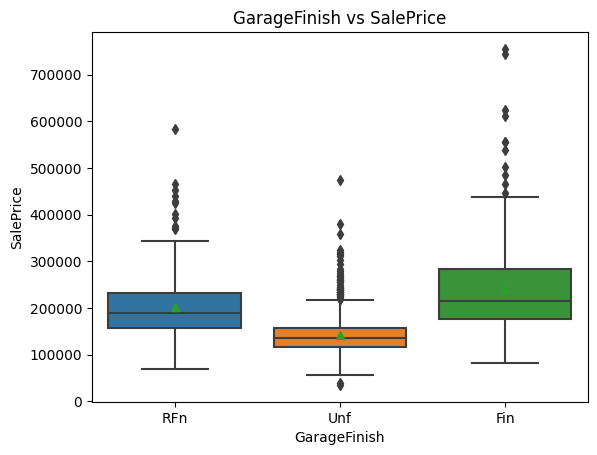

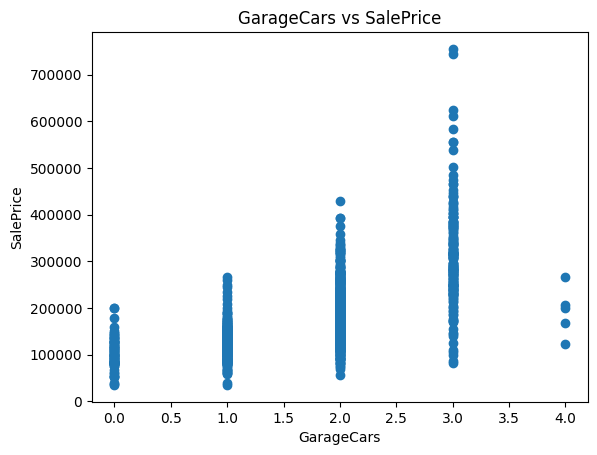

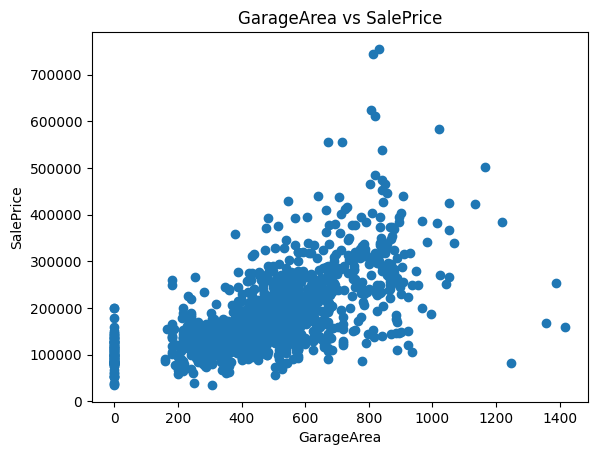

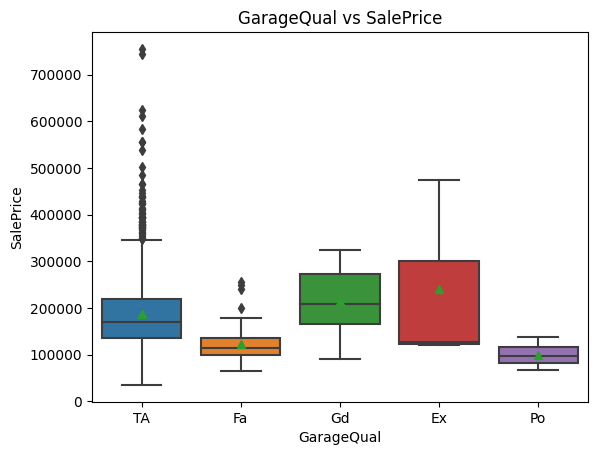

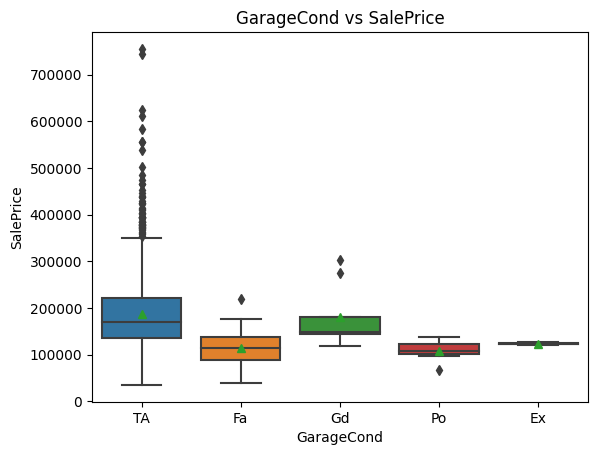

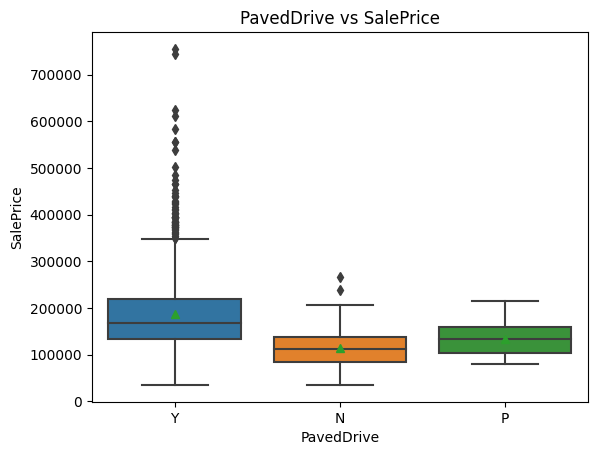

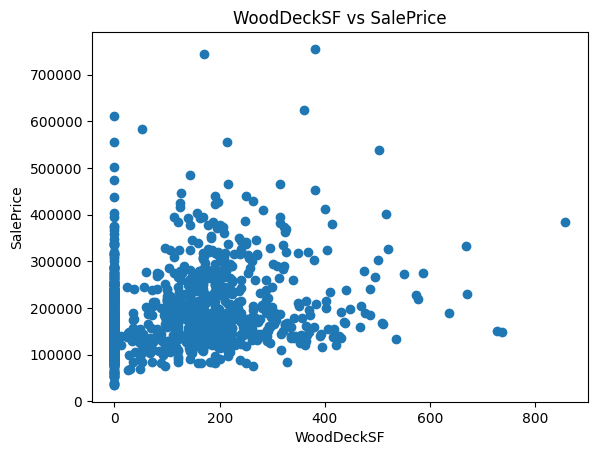

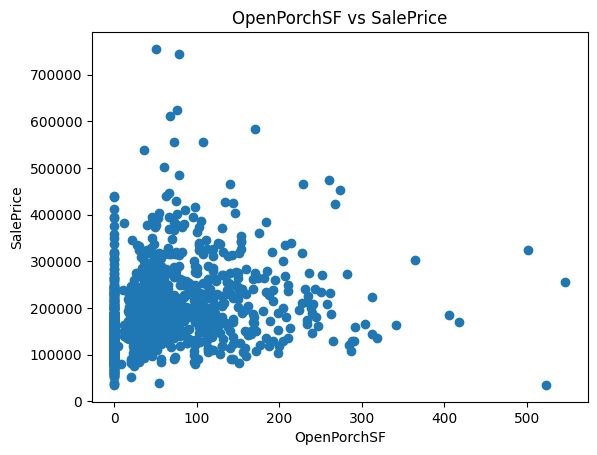

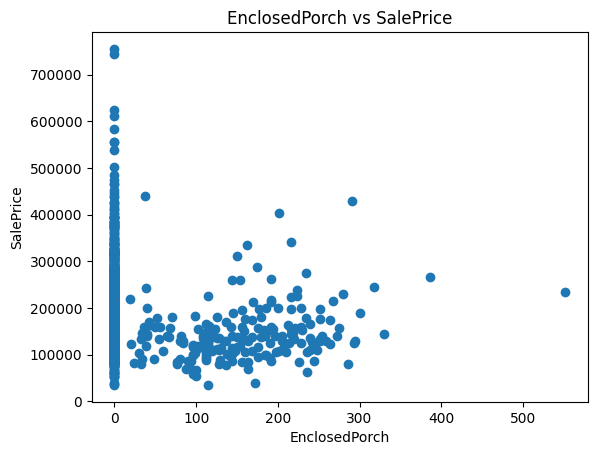

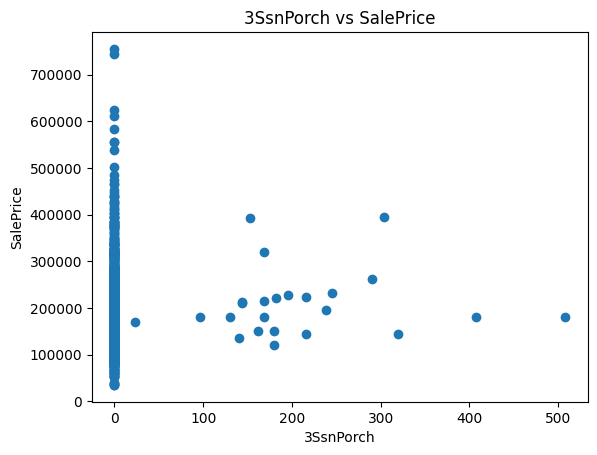

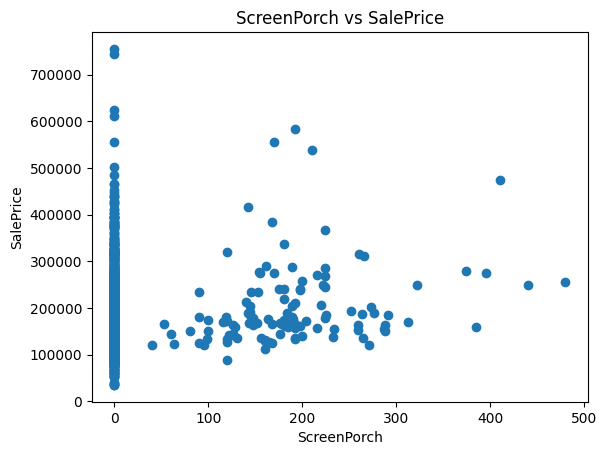

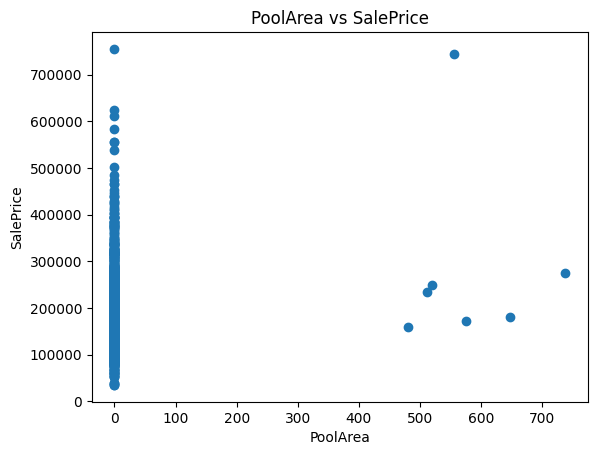

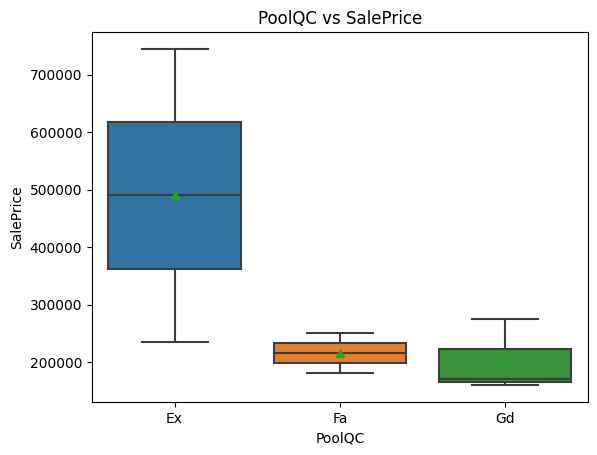

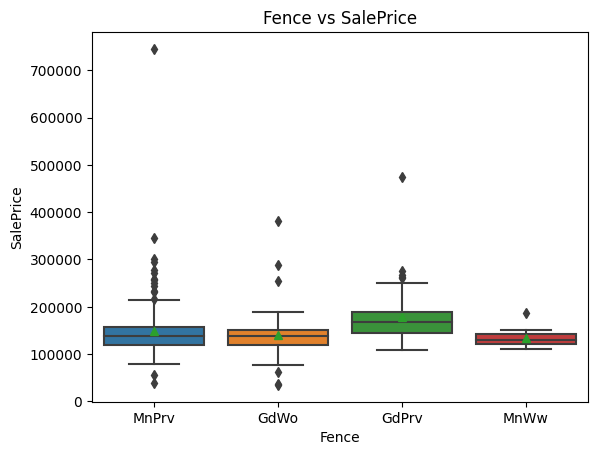

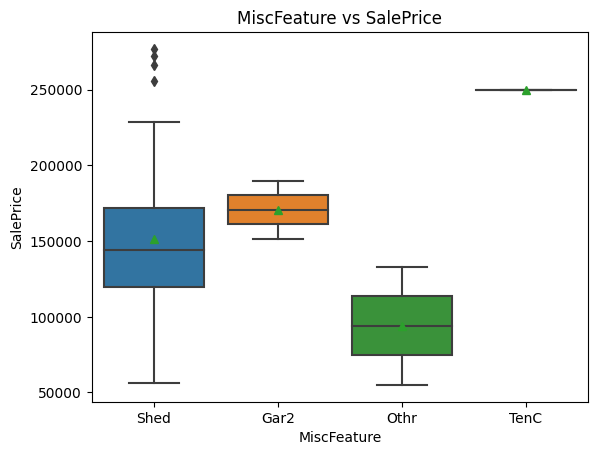

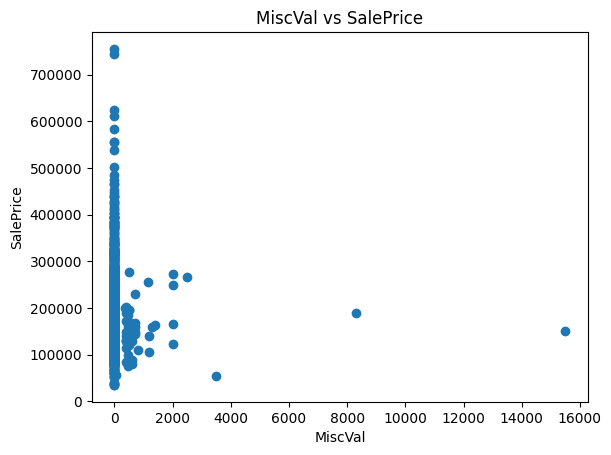

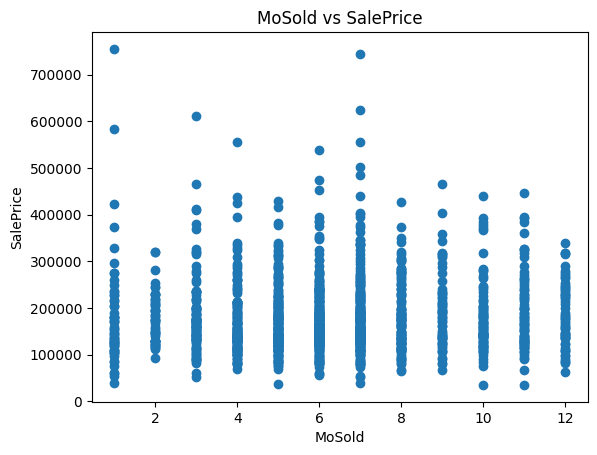

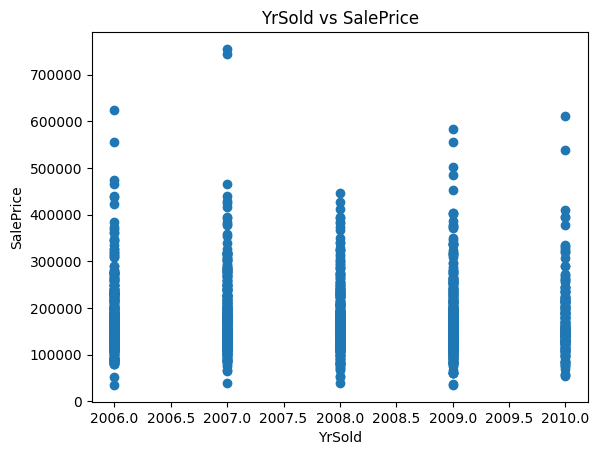

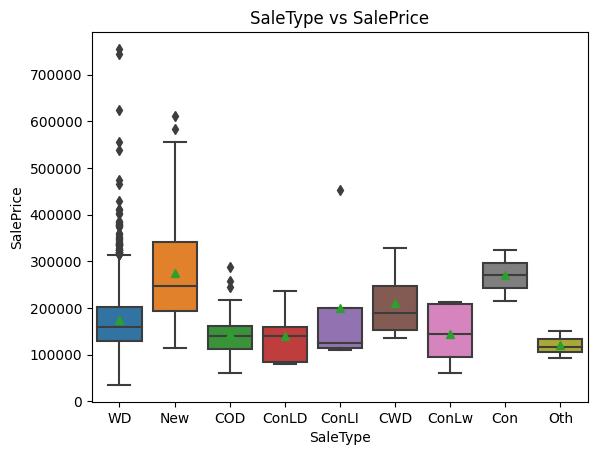

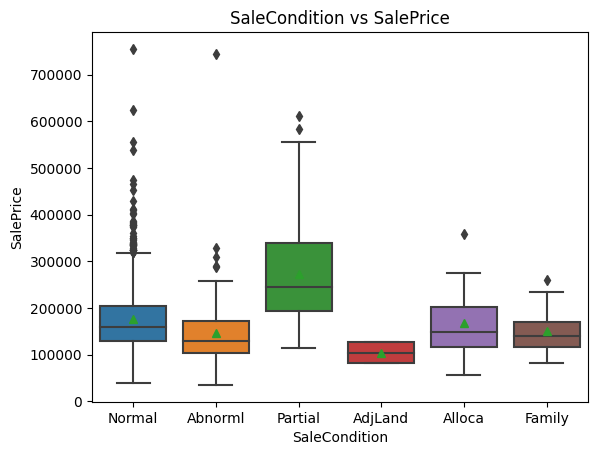

In [14]:
target = train_set.iloc[:, -1]
for column in train_set.columns[:-1]:  # Exclude the last column which is the target
    plt.figure()
    
    column_type = train_set[column].dtype
    if column_type == 'object':
        sns.boxplot(x=train_set[column], y=target, showmeans=True)
    else: 
        plt.scatter(train_set[column], target)
    
    plt.xlabel(column)
    plt.ylabel(train_set.columns[-1])
    plt.title(f'{column} vs {train_set.columns[-1]}')
    plt.show()

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count     74.0
unique    46.0
top        0.0
freq      10.0
Name: 1459, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

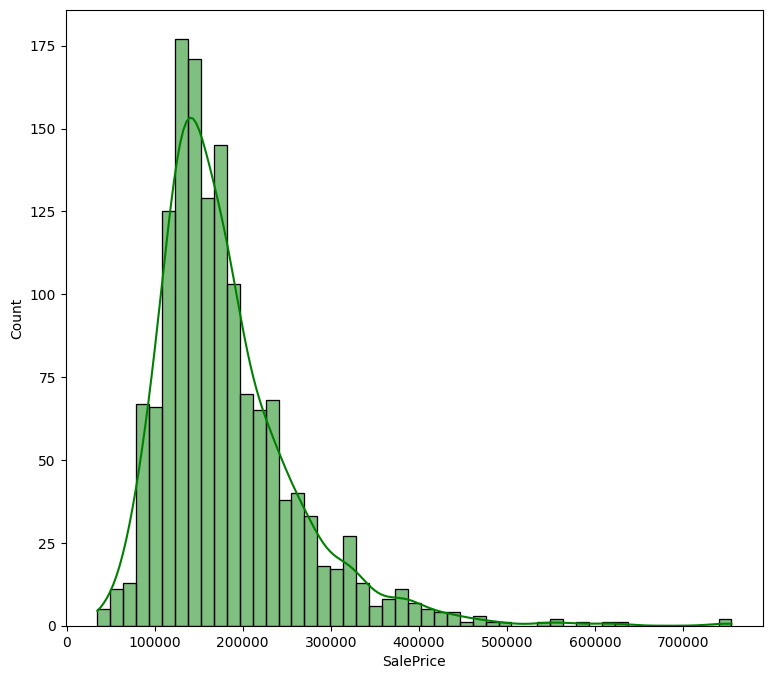

In [15]:
print(train_set.iloc[-1].describe())
plt.figure(figsize=(9, 8))
sns.histplot(target, color='g', kde=True)

## Data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

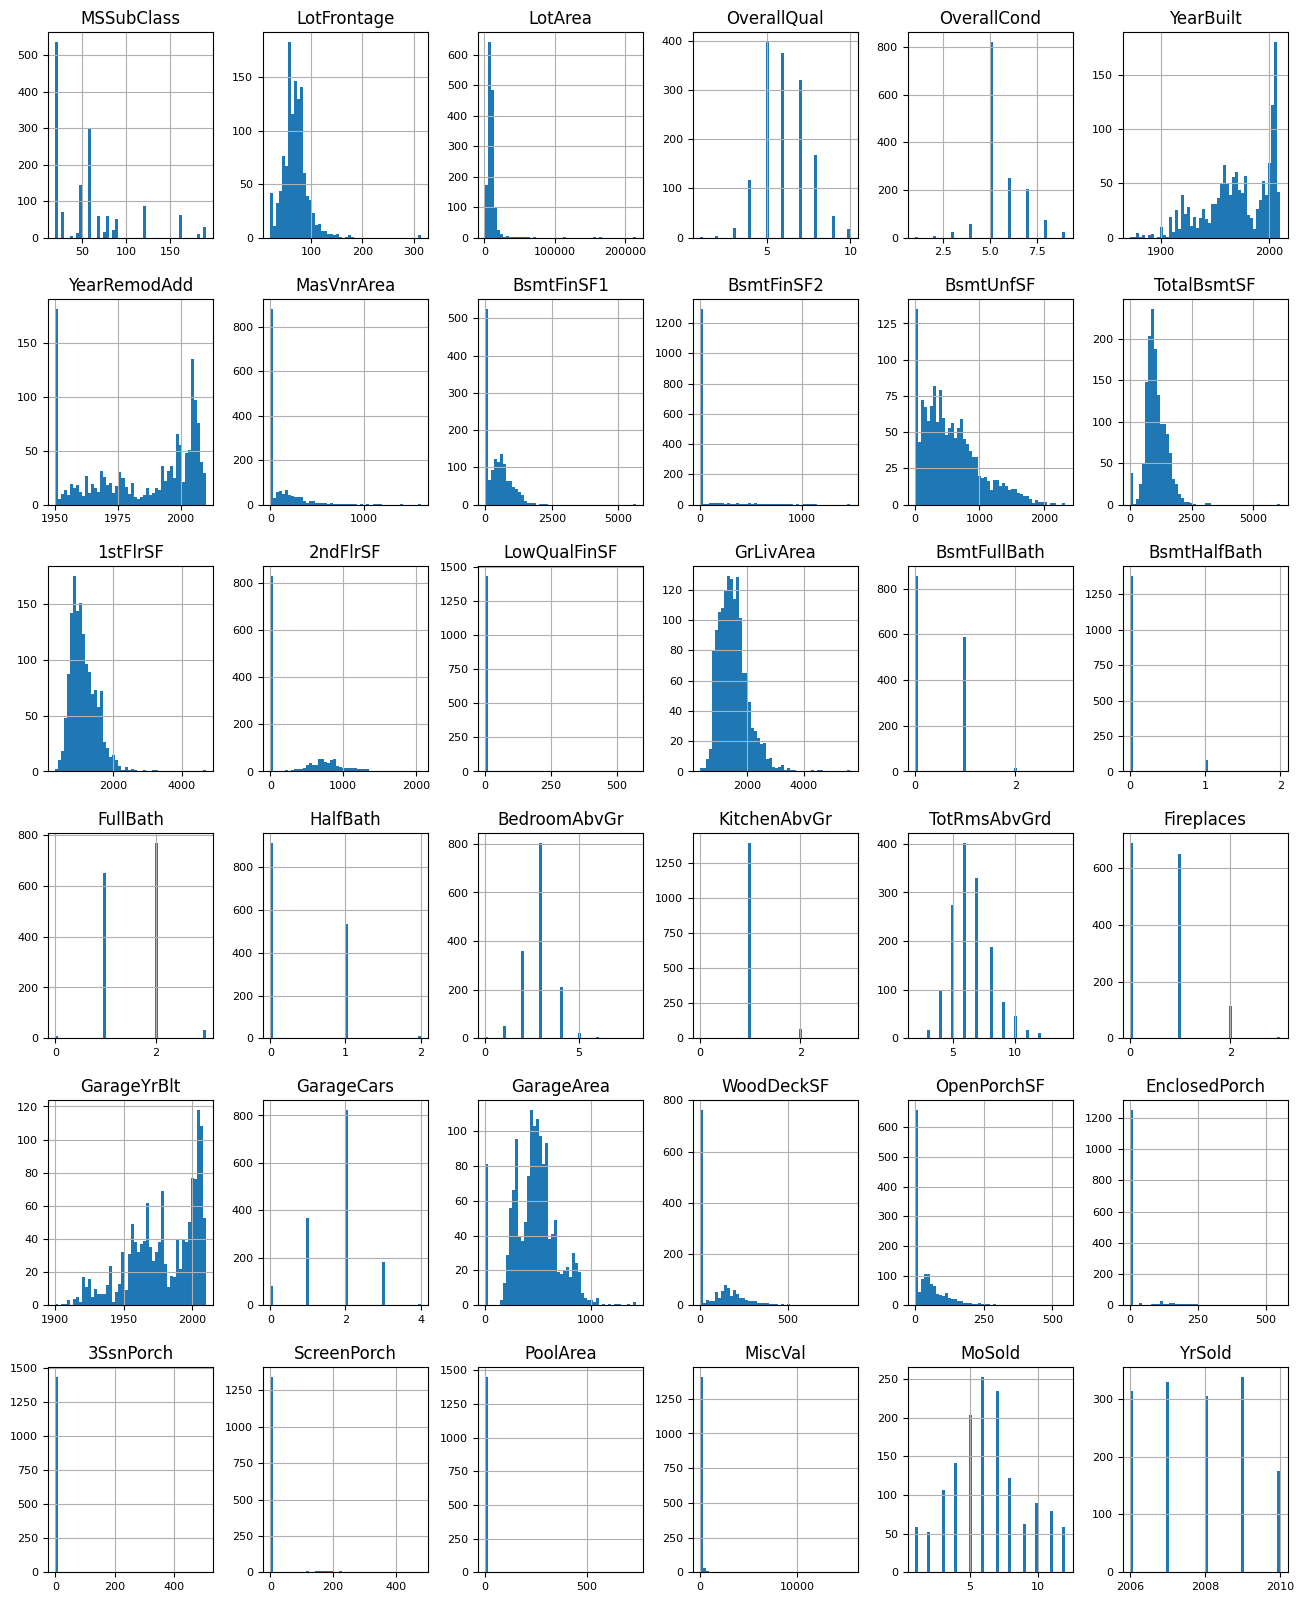

In [16]:
# Numerical type
df_num = train_set.select_dtypes(include = ['float64', 'int64']).drop(columns=['SalePrice'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [17]:
# Categorical type
df_cate = train_set.select_dtypes(include = ['object'])   
for col in df_cate.columns:
    unique_values = df_cate[col].unique()
    print(f"{col:<{15}} : {unique_values}")

MSZoning        : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street          : ['Pave' 'Grvl']
Alley           : [nan 'Grvl' 'Pave']
LotShape        : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour     : ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities       : ['AllPub' 'NoSeWa']
LotConfig       : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope       : ['Gtl' 'Mod' 'Sev']
Neighborhood    : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1      : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2      : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType        : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle      : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle       : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofM

# Prepare dataset

In [18]:
X = train_set.iloc[:, :-1].values
y = train_set.iloc[:, -1].values

## Take care of missing data

Impute missing data using SimpleImputer


In [19]:
# Separate the data into categorical and numerical columns
categorical_columns = []
numerical_columns = []
for i, col in enumerate(train_set.columns):
    if train_set[col].dtype == 'object':
        categorical_columns.append(i)
    else:
        numerical_columns.append(i)

numerical_columns.pop()

79

In [20]:
# Numerical - median
nume_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# Categorical
cate_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Impute missing values in categorical columns
if categorical_columns:
    X[:, categorical_columns] = cate_imputer.fit_transform(X[:, categorical_columns])

# Impute missing values in numerical columns
if numerical_columns:
    X[:, numerical_columns] = nume_imputer.fit_transform(X[:, numerical_columns])

## Feature scaling

In [21]:
sc = StandardScaler()
# .fit only compute the mean and the standard deviation
X[:, numerical_columns] = sc.fit_transform(X[:, numerical_columns])

## Encoding categorical data

This dataset contains a mix of numeric, categorical. 

In [22]:
# If dont have remainder, columns are not transformed will be dropped
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_columns)], remainder='passthrough')
X = ct.fit_transform(X)

## Visualize

In [23]:
# Convert sparse matrix to dense array
X_dense = X.toarray()

# Create a DataFrame from the dense array
X_df = pd.DataFrame(X_dense)

# Visualize the DataFrame
print(X_df.head())

   0    1    2    3    4    5    6    7    8    9    ...       277       278  \
0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.351000 -0.752176   
1  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  ... -0.060731  1.626195   
2  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  0.631726 -0.752176   
3  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  0.790804 -0.752176   
4  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  1.698485  0.780197   

        279       280       281       282       283       284       285  \
0  0.216503 -0.359325 -0.116339 -0.270208 -0.068692 -0.087688 -1.599111   
1 -0.704483 -0.359325 -0.116339 -0.270208 -0.068692 -0.087688 -0.489110   
2 -0.070361 -0.359325 -0.116339 -0.270208 -0.068692 -0.087688  0.990891   
3 -0.176048  4.092524 -0.116339 -0.270208 -0.068692 -0.087688 -1.599111   
4  0.563760 -0.359325 -0.116339 -0.270208 -0.068692 -0.087688  2.100892   

        286  
0  0.138777  
1 -0.614439  
2  0.138777  
3 -1.367655 

## Split the dataset into training and testing datasets:

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_dense, y, test_size = 0.2, random_state = 1)

# Choose and train several model

## Multiple Linear Regresion

In [25]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_regressor = regressor.predict(X_validate)

In [49]:
print(sum(abs(y_pred_regressor - y_validate)))

4.5443447050588845e+17


In [35]:
y_pred_regressor[0]

213520.0

## Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 3)
X_poly = poly_reg.fit_transform(X_train)
poly = LinearRegression()
poly.fit(X_poly, y_train)
y_pred_poly = poly.predict(X_validate)

## Support Vector Regression

In [26]:
from sklearn.svm import SVR
# Gaussian RBF Kernel
sv_regressor = SVR(kernel = 'rbf')
# Training
sv_regressor.fit(X_train, y_train)
y_pred_SVR = sv_regressor.predict(X_validate)

In [51]:
print(sum(abs(y_pred_SVR - y_validate)**0.5))

61849.70161580761


In [39]:
y_validate[0]

231500

## Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_regressor.fit(X_train, y_train)
y_pred_tree = tree_regressor.predict(X_validate)

In [40]:
y_pred_tree[0]

192500.0

## Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators = 1000, random_state = 0)
forest_regressor.fit(X_train, y_train)
y_pred_forest = forest_regressor.predict(X_validate)

In [52]:
print(sum(abs(y_pred_forest - y_validate)**0.5))

32506.55152165219


In [69]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission_ver2.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 20ms/step


,Id,SalePrice
0,1461,130887.703125
1,1462,153571.968750
2,1463,184559.265625
3,1464,186591.000000
4,1465,199327.187500
